## Introduction

In [29]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# Load csv
mouse_drug_data_to_load = "mouse_drug_data.csv"
clinical_trial_data_to_load = "clinicaltrial_data.csv"

# Read the Mouse and Drug Data and the Clinical Trial Data
mouse_df = pd.read_csv(mouse_drug_data_to_load)
trial_df = pd.read_csv(clinical_trial_data_to_load)

# Combine the data into a single dataset (mt = mouse trial)
mt_df = pd.merge(mouse_df, trial_df, on = "Mouse ID")

# Display the data table for preview
mt_df.head()

mt_df.loc[mt_df["Mouse ID"] == "g989"]

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
41,g989,Stelasyn,0,45.000000,0
42,g989,Stelasyn,0,45.000000,0
43,g989,Stelasyn,5,48.786801,0
44,g989,Stelasyn,5,47.570392,0
45,g989,Stelasyn,10,51.745156,0
46,g989,Stelasyn,10,49.880528,0
47,g989,Stelasyn,15,51.325852,1
48,g989,Stelasyn,15,53.442020,0
49,g989,Stelasyn,20,55.326122,1
50,g989,Stelasyn,20,54.657650,1


## Study overview
The study appears to have used a repeated measures design. This means that the same group of mice were subjected to the same drug and the effects were measured over time. The response variables were the tumour volumes, the numbers of metastatic sites, and number of mice surviving per unit time. 

For the number of mice used, the data identifies 249 unique mice. Apparently, one mouse ID was used for two treatments: Stelasyn (0–35 days) and Propriva (0–35 days). The results were identical; it might be ideal to remove this Mouse ID from the analyses (NOTE: Will do on Oct 10th).

In [25]:
# list of subjects and treatments
mouse = mt_df["Mouse ID"].unique()
drugs = mt_df["Drug"].unique()
time = mt_df["Timepoint"].unique()

# counts of subjects and treatments
mouse_popn = len(mouse)
no_drugs = len(drugs)
no_measurements = len(time)
no_samples = no_drugs * no_measurements

# summarise in a dataframe
overview = pd.DataFrame({"Number of Mice": mouse_popn,
                         "Number of Drug Treatments": [no_drugs],
                         "Number of Time Measurements": [no_measurements],
                         "Number of Samples": [no_samples]})
overview

,Number of Mice,Number of Drug Treatments,Number of Time Measurements,Number of Samples
0,249,10,10,100


## Tumor Response to Treatment

In [3]:
# Group the data by drug and timepoint
mt_df2 = mt_df.drop("Metastatic Sites", axis = 1)
mt_grped = mt_df2.groupby(["Drug","Timepoint"])

# Get the mean and SEM of tumour volume
tumour_means = pd.DataFrame(mt_grped["Tumor Volume (mm3)"].mean()) # mean for each Drug-Timepoint combination
tumour_sem = pd.DataFrame(mt_grped["Tumor Volume (mm3)"].sem()) # SEM for each Drug-Timepoint combination

# reshape the data
tumour_means = tumour_means.unstack(0)
tumour_sem = tumour_sem.unstack(0)

tumour_means = tumour_means["Tumor Volume (mm3)"]
tumour_sem = tumour_sem["Tumor Volume (mm3)"]

In [5]:
# Choose ggplot as style for plots
plt.style.use('ggplot')

# Size of plots
fig_size = plt.rcParams["figure.figsize"] # get current size
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size # customise plot size

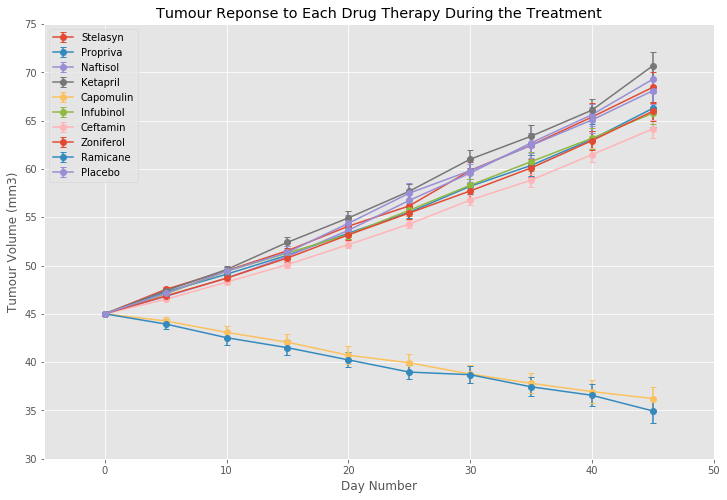

In [6]:
# Plot means and SE

x_axis = np.arange(0, time.max() + 5, 5) # time
no_series = np.arange(0,no_drugs)

for i in no_series:
    std_error = tumour_sem[drugs[i]]
    plt.errorbar(x_axis, 
                 tumour_means[drugs[i]], 
                 yerr = std_error, 
                 marker = "o", capsize = 3)
    plt.title("Tumour Reponse to Each Drug Therapy During the Treatment")
    plt.xlabel("Day Number")
    plt.ylabel("Tumour Volume (mm3)")
    plt.xlim(-5, max(time) + 5)
    plt.ylim(30, 75)
    plt.legend()
    plt.savefig("Images/tumour_v_time.png")

## Metastatic Response to Treatment

In [7]:
mt_df3 = mt_df.drop("Tumor Volume (mm3)", axis = 1)
mt_grped2 = mt_df3.groupby(["Drug","Timepoint"])

# Get the mean of metastasis sites and convert to dataframe
metastatic_series = mt_grped2["Metastatic Sites"].mean()
metastatic_df = metastatic_series.to_frame().reset_index()

# Preview DataFrame
metastatic_df.head()

,Drug,Timepoint,Metastatic Sites
0,Capomulin,0,0.000000
1,Capomulin,5,0.160000
2,Capomulin,10,0.320000
3,Capomulin,15,0.375000
4,Capomulin,20,0.652174


In [8]:
# Get the mean and SEM of tumour volume
meta_means = pd.DataFrame(mt_grped2["Metastatic Sites"].mean()) # mean for each Drug-Timepoint combination
meta_sem = pd.DataFrame(mt_grped2["Metastatic Sites"].sem()) # SEM for each Drug-Timepoint combination

# reshape the data
meta_means = meta_means.unstack(0)
meta_sem = meta_sem.unstack(0)

meta_means = meta_means["Metastatic Sites"]
meta_sem = meta_sem["Metastatic Sites"]

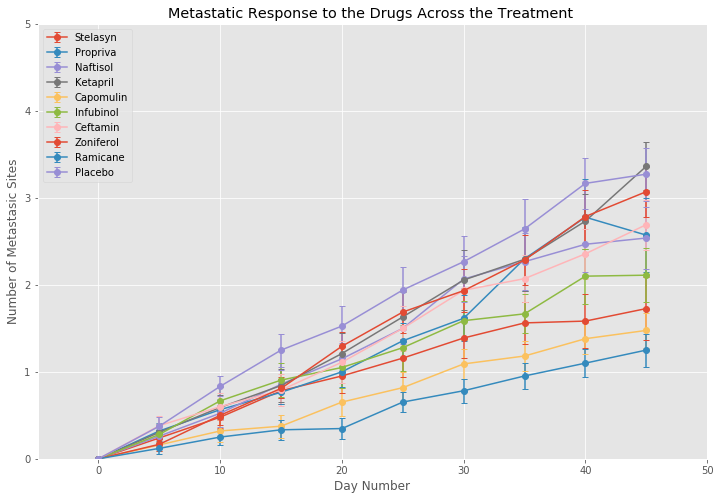

In [10]:
# Plot means and SE

x_axis = np.arange(0,time.max() + 5, 5) # time
no_series = np.arange(0,no_drugs)

for i in no_series:
    std_error = meta_sem[drugs[i]]
    plt.errorbar(x_axis, 
                 meta_means[drugs[i]], 
                 yerr = std_error, 
                 marker = "o", capsize = 3)
    plt.title("Metastatic Response to the Drugs Across the Treatment ")
    plt.xlabel("Day Number")
    plt.ylabel("Number of Metastasic Sites")
    plt.xlim(-5, max(time) + 5)
    plt.ylim(0, 5)
    plt.legend()
    plt.savefig("Images/meta_v_time.png")

## Survival Rates

In [11]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
no_mice = mt_grped["Mouse ID"].count()
no_mice = pd.DataFrame(no_mice.unstack(0))
no_mice

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,25,25,25,25,25,25,26,25,26,25
5,25,21,25,23,23,24,25,25,25,24
10,25,20,21,22,21,24,23,24,23,22
15,24,19,21,19,21,20,17,24,23,21
20,23,18,20,19,20,19,17,23,21,17
25,22,18,18,19,18,17,14,23,19,16
30,22,16,17,18,15,15,13,23,18,15
35,22,14,12,17,15,14,10,21,16,14
40,21,14,10,15,15,12,9,20,12,14


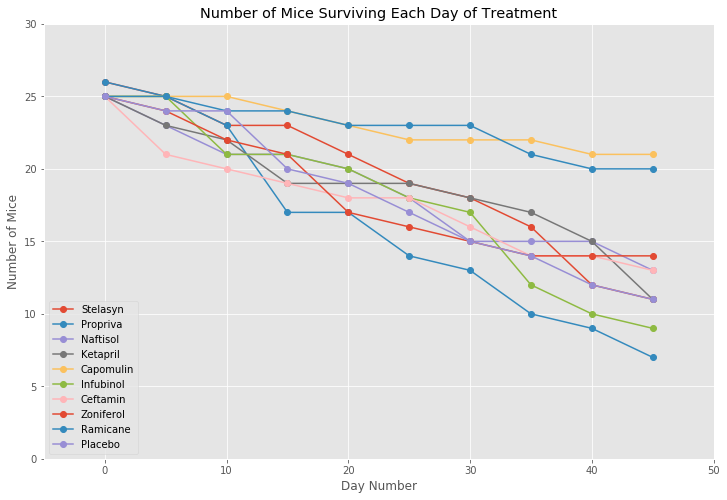

In [12]:
# Plot number of surviving mice per unit time

x_axis = np.arange(0,time.max() + 5, 5) # time
no_series = np.arange(0,no_drugs)

for i in no_series:
    plt.plot(x_axis, 
             no_mice[drugs[i]], 
             marker = "o")
    plt.title("Number of Mice Surviving Each Day of Treatment")
    plt.xlabel("Day Number")
    plt.ylabel("Number of Mice")
    plt.xlim(-5, max(time) + 5)
    plt.ylim(0, 30)
    plt.legend()
    plt.savefig("Images/mice_v_time.png")

Mouse survival rate calculations followed Nohrmann (1953).

In [13]:
# Mouse mortality values
mortality = (abs(no_mice.diff()) / no_mice)
mortality["time"] = time
mortality

# survival = 1 - mouse mortality
def survive(x): # where x is the index of time (range: time[1] = 5 to time[9] = 45)
    return 1 - mortality.iloc[x,0:10]

surv_t05 = survive(1)
surv_t10 = survive(2)
surv_t15 = survive(3)
surv_t20 = survive(4)
surv_t25 = survive(5)
surv_t30 = survive(6)
surv_t35 = survive(7)
surv_t40 = survive(8)
surv_t45 = survive(9)

# survival rate per year
survival_rate_t05 = 100 * surv_t05
survival_rate_t10 = 100 * surv_t05 * surv_t10
survival_rate_t15 = 100 * surv_t05 * surv_t10 * surv_t15
survival_rate_t20 = 100 * surv_t05 * surv_t10 * surv_t15 * surv_t20
survival_rate_t25 = 100 * surv_t05 * surv_t10 * surv_t15 * surv_t20 \
                        * surv_t25
survival_rate_t30 = 100 * surv_t05 * surv_t10 * surv_t15 * surv_t20 \
                        * surv_t25 * surv_t30
survival_rate_t35 = 100 * surv_t05 * surv_t10 * surv_t15 * surv_t20 \
                        * surv_t25 * surv_t30 * surv_t35
survival_rate_t40 = 100 * surv_t05 * surv_t10 * surv_t15 * surv_t20 \
                        * surv_t25 * surv_t30 * surv_t35 * surv_t40
survival_rate_t45 = 100 * surv_t05 * surv_t10 * surv_t15 * surv_t20 \
                        * surv_t25 * surv_t30 * surv_t35 * surv_t40 \
                        * surv_t45

survival_rates = pd.DataFrame(dict(survival_rate_t05 = survival_rate_t05,
                                   survival_rate_t10 = survival_rate_t10,
                                   survival_rate_t15 = survival_rate_t15,
                                   survival_rate_t20 = survival_rate_t20,
                                   survival_rate_t25 = survival_rate_t25,
                                   survival_rate_t30 = survival_rate_t30,
                                   survival_rate_t35 = survival_rate_t35,
                                   survival_rate_t40 = survival_rate_t40,
                                   survival_rate_t45 = survival_rate_t45))
survival_rates = survival_rates.rename(columns = {"survival_rate_t05": "t05",
                                                  "survival_rate_t10": "t10",
                                                  "survival_rate_t15": "t15",
                                                  "survival_rate_t20": "t20",
                                                  "survival_rate_t25": "t25",
                                                  "survival_rate_t30": "t30",
                                                  "survival_rate_t35": "t35",
                                                  "survival_rate_t40": "t40",
                                                  "survival_rate_t45": "t45"})
sr1 = survival_rates.transpose() # use the drug names as the keys in the dataframe
sr1

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
t05,100.000000,80.952381,100.000000,91.304348,91.304348,95.833333,96.000000,100.000000,96.000000,95.833333
t10,100.000000,76.904762,80.952381,87.154150,82.608696,95.833333,87.652174,95.833333,87.652174,87.121212
t15,95.833333,72.857143,80.952381,73.392969,82.608696,76.666667,56.716113,95.833333,87.652174,82.972583
t20,91.666667,68.809524,76.904762,73.392969,78.478261,72.631579,56.716113,91.666667,79.304348,63.449622
t25,87.500000,68.809524,68.359788,73.392969,69.758454,64.086687,44.562660,91.666667,70.956522,59.484021
t30,87.500000,60.208333,64.338624,69.315581,55.806763,55.541796,41.134763,91.666667,67.014493,55.518419
t35,87.500000,51.607143,37.530864,65.238194,55.806763,51.574525,28.794334,82.936508,58.637681,51.552818
t40,83.333333,51.607143,30.024691,56.539768,55.806763,42.978770,25.594964,78.789683,39.091787,51.552818
t45,83.333333,47.637363,26.688615,35.979853,47.221107,39.071610,18.282117,78.789683,35.537989,51.552818


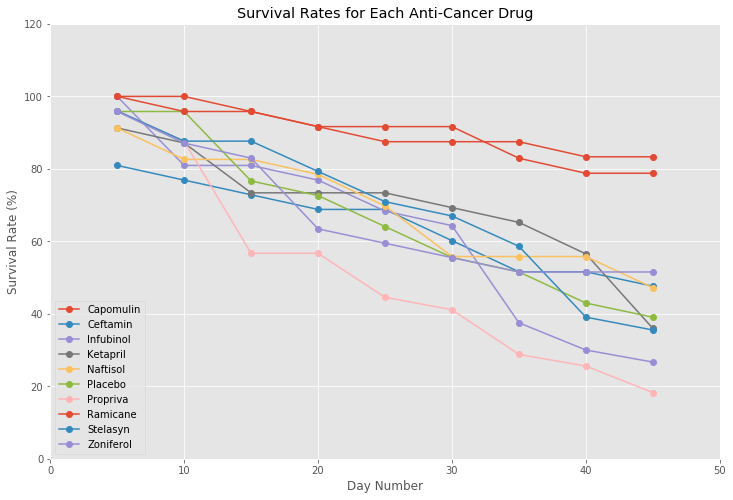

In [14]:
# Plot survival rates

plt.plot(np.delete(time, 0), 
        sr1, 
        marker = "o")
plt.title("Survival Rates for Each Anti-Cancer Drug")
plt.xlabel("Day Number")
plt.ylabel("Survival Rate (%)")
plt.xlim(0, max(time) + 5)
plt.ylim(0, 120)
plt.legend(sr1.keys())
plt.savefig("Images/pct_mice_v_time.png")

## Tumour size changes

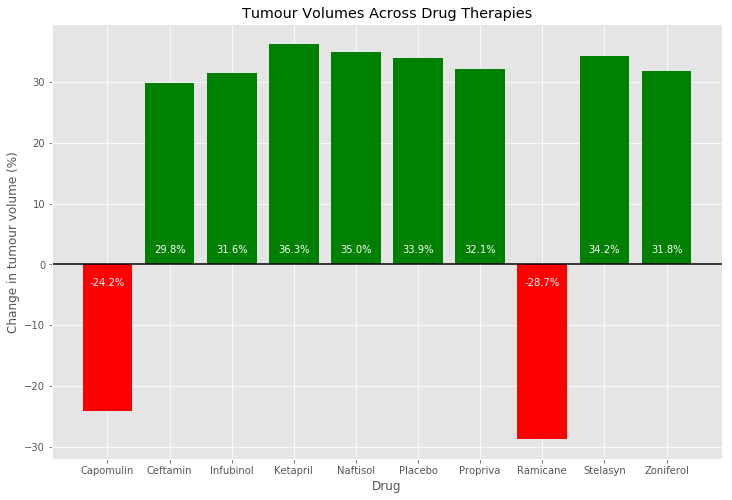

In [22]:
# Filter values to get the data for start and end points of the study
a = tumour_means.iloc[0] # time 00
j = tumour_means.iloc[9] # time 45
xlabels = tumour_means.keys()

# % tumour size change between time 0 and time 45
pct_tumour_change = round((((j - a) / j) * 100),2)
pct_tumour_change

# graph the tumour changes
plt.bar(no_series,
    pct_tumour_change,
    color = ["green" if pct_tumour_change[i] > 0 else "red" for i in no_series])
plt.xticks(no_series, xlabels)
plt.title("Tumour Volumes Across Drug Therapies")
plt.xlabel("Drug")
plt.ylabel("Change in tumour volume (%)")
plt.axhline(y = 0, color = "black")

# Add label inside the bar graph (%)
count = 0

for i in pct_tumour_change:
    if i < 0:
        y_coord = -3.5
    else:
        y_coord = 2
    plt.text(count, y_coord, str(round(i, 1)) + '%', ha = 'center', color = 'white')
    count += 1

plt.savefig("Images/tumour_v_drug.png")
plt.show()

Drug       Capomulin  Ceftamin  Infubinol  Ketapril  Naftisol   Placebo  \
Timepoint                                                                 
0                NaN       NaN        NaN       NaN       NaN       NaN   
5          -1.657959  3.232156   4.381456  5.041604  3.838136  4.510478   
10         -2.742985  3.690731   4.740328  4.423143  3.898023  4.649101   
15         -2.424794  3.611067   3.689320  5.377302  4.395594  3.770292   
20         -3.310692  3.955350   3.574017  4.590164  5.053808  5.526915   
25         -1.944934  3.924695   4.518622  4.781719  5.442928  5.424525   
30         -3.018335  4.371788   4.432541  5.435777  4.747422  3.889861   
35         -2.518720  3.498413   4.022004  3.751169  4.986159  4.183797   
40         -2.323822  4.295491   3.831943  4.081962  4.444563  4.046044   
45         -1.992176  4.154725   3.942994  6.501819  5.290877  4.452446   

Drug       Propriva  Ramicane  Stelasyn  Zoniferol  
Timepoint                                     

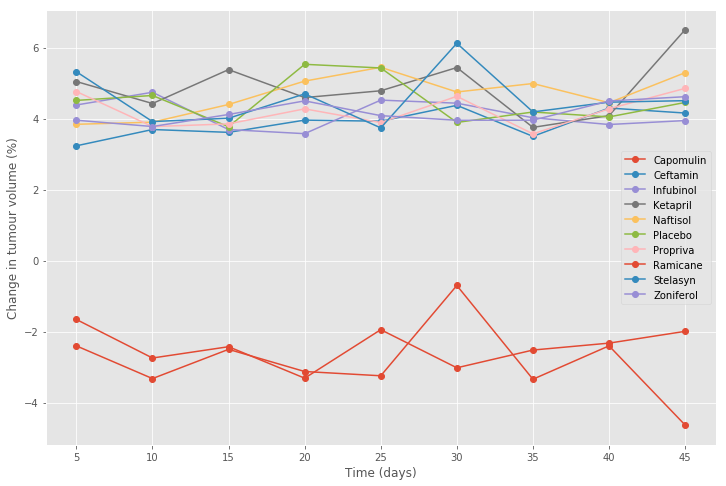

In [16]:
# Data transformation to get %tumour size change
pct_tumour_change = (tumour_means.diff() / tumour_means) * 100

print(pct_tumour_change)

# Prepare plot of tumour change vs time
plt.plot(x_axis,
        pct_tumour_change,
        marker = "o")

plt.xlabel("Time (days)")
plt.ylabel("Change in tumour volume (%)")
plt.legend(tumour_means.keys())
plt.savefig("Images/tumourchange_v_time.png")
plt.show()

## Comparison of Means per Day

In [17]:
# Rename columns (pythonic)
mt_df4 = mt_df.rename(columns = {"Tumor Volume (mm3)": "tumour_size",
                                 "Metastatic Sites": "meta_sites"})

In [18]:
# Use a function to generate dataframes by timepoint
def find_values(x):
    return mt_df4.loc[mt_df4["Timepoint"] == x]

df_00 = find_values(0)
df_05 = find_values(5)
df_10 = find_values(10)
df_15 = find_values(15)
df_20 = find_values(20)
df_25 = find_values(25)
df_30 = find_values(30)
df_35 = find_values(35)
df_40 = find_values(40)
df_45 = find_values(45)

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


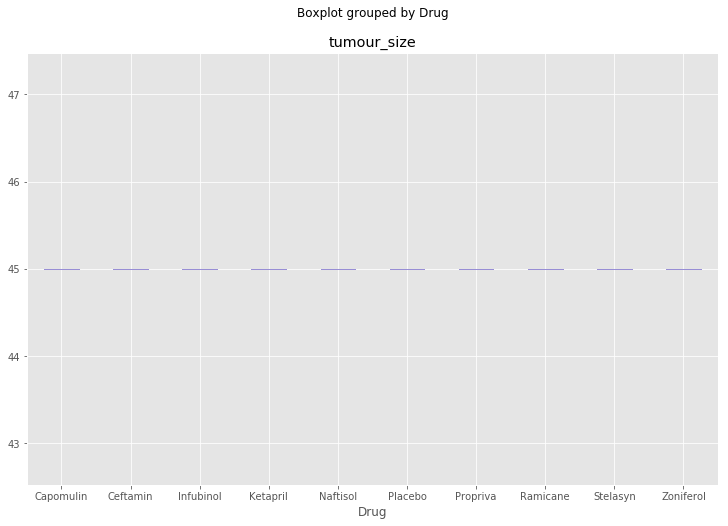

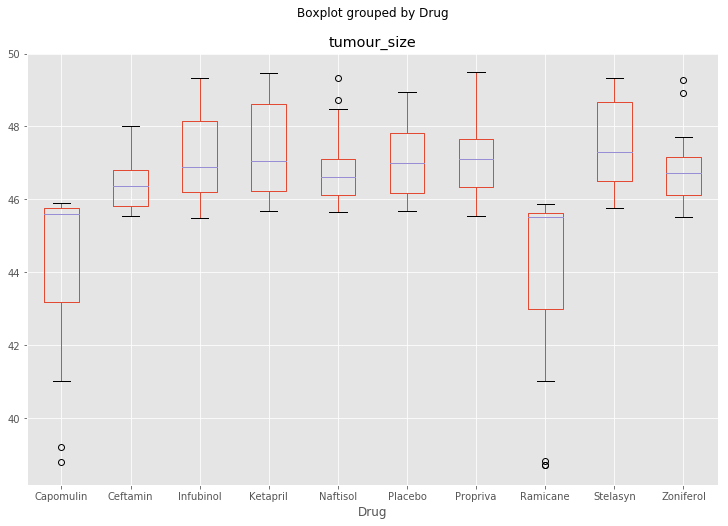

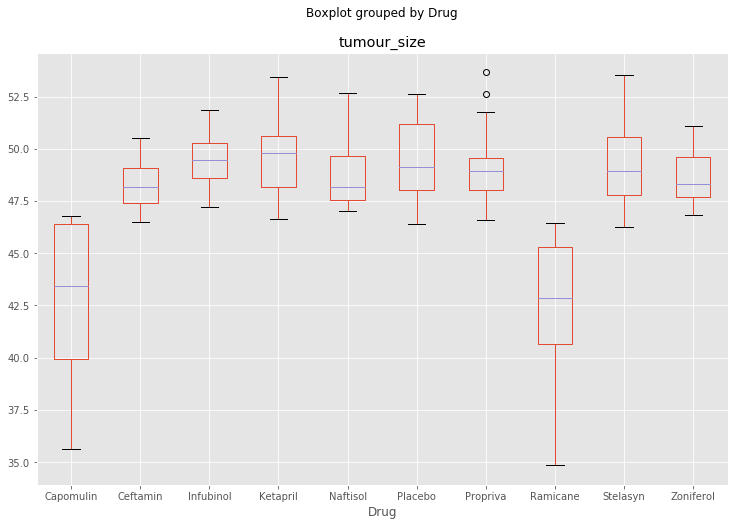

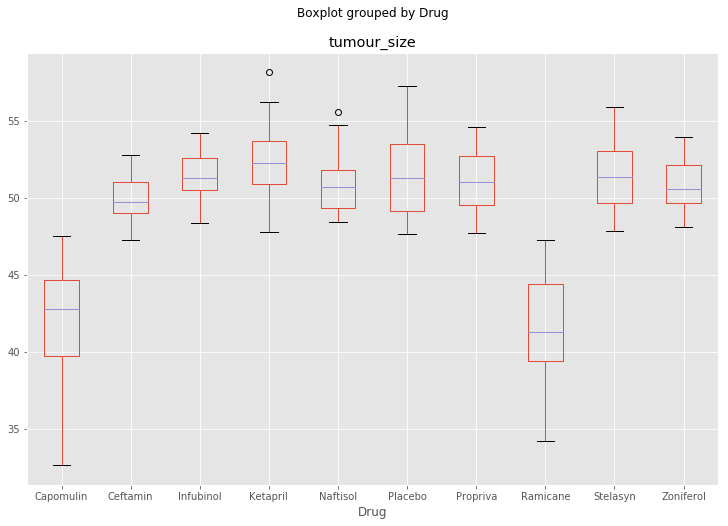

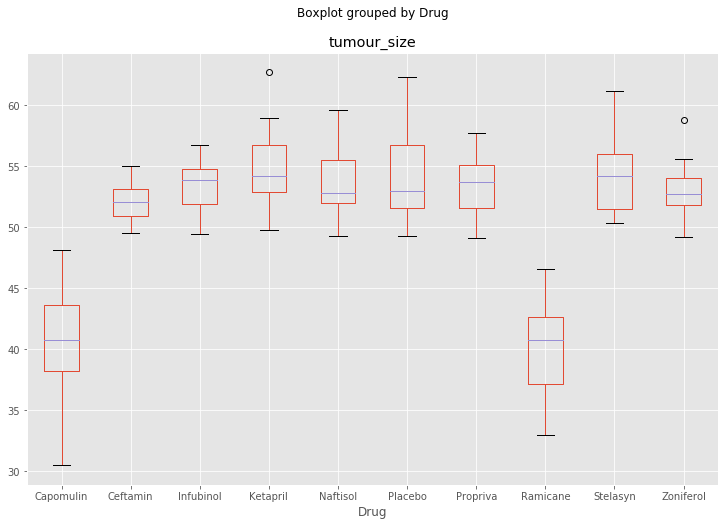

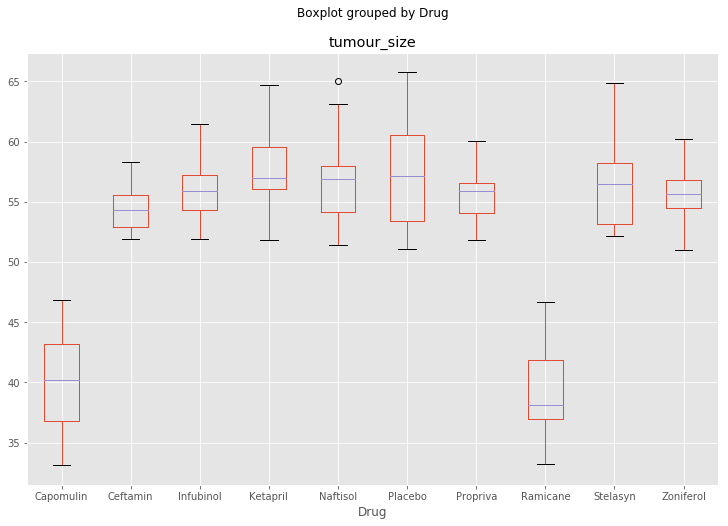

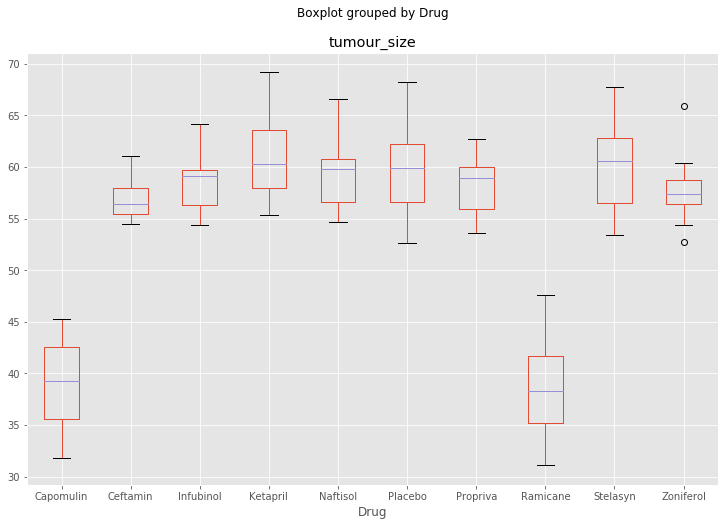

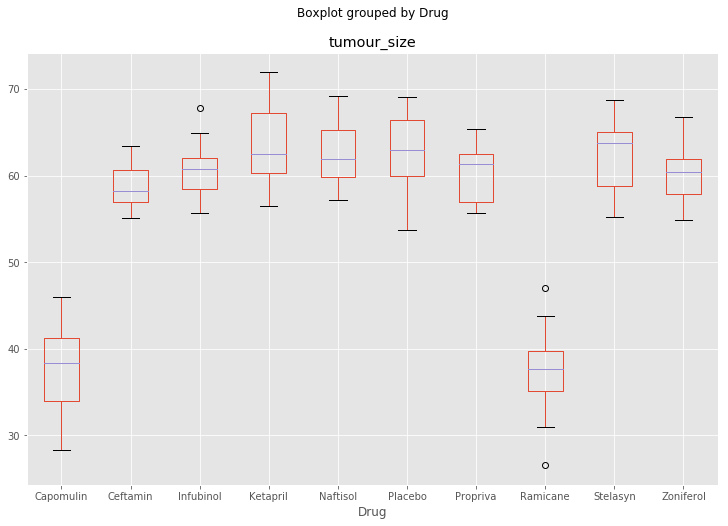

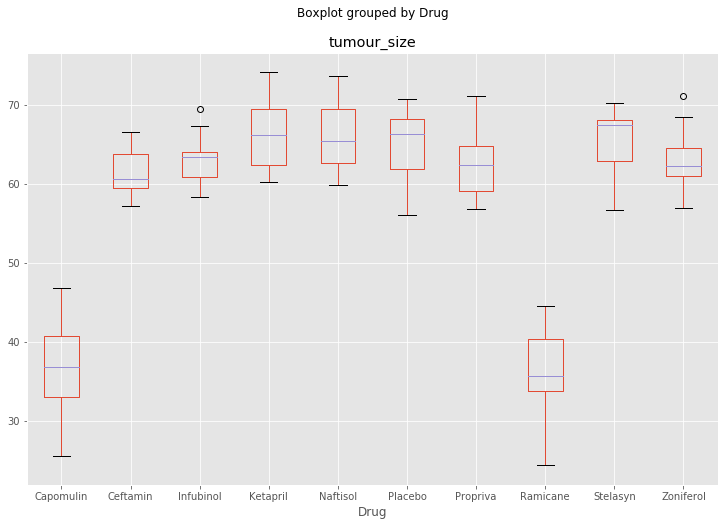

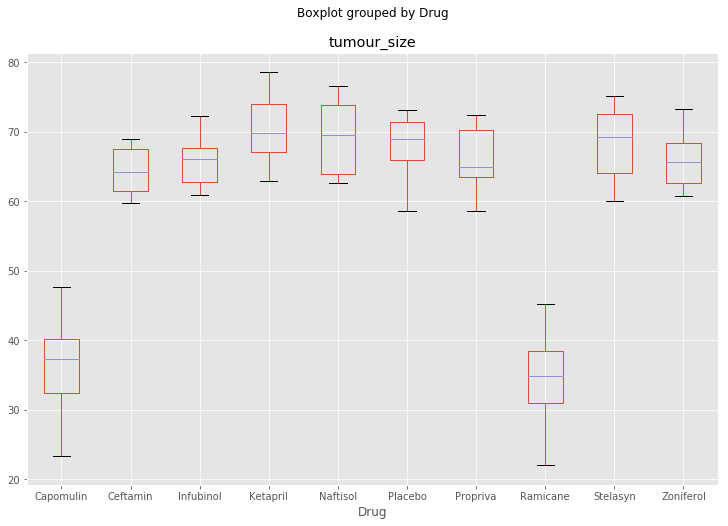

In [19]:
# create boxplots to determine spread of data per timepoint
def bp(df):
    return df.boxplot("tumour_size", by = "Drug")

p1 = bp(df_00)
p2 = bp(df_05)
p3 = bp(df_10)
p4 = bp(df_15)
p5 = bp(df_20)
p6 = bp(df_25)
p7 = bp(df_30)
p8 = bp(df_35)
p9 = bp(df_40)
p10 = bp(df_45)

print(p1)
print(p2)
print(p3)
print(p4)
print(p5)
print(p6)
print(p7)
print(p8)
print(p9)
print(p10)

## Comparison of Means Among Samples


In [20]:
# Comparison of tumour means by two-way ANOVA
formula = 'tumour_size ~ C(Drug) * C(Timepoint)'

model = smf.ols(formula, mt_df4).fit()

# aov = sm.stats.anova_lm(model, typ = 2)

# Is the overall model significant?
print(f"Overall tumour volume model F({model.df_model:.0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall tumour volume model F(99, 1806) =  146.396, p =  0.0000


In [21]:
# Comparison of metastatic site means by two-way ANOVA
formula1 = 'meta_sites ~ C(Drug) : C(Timepoint)'

model1 = smf.ols(formula1, mt_df4).fit()

aov1 = sm.stats.anova_lm(model1, typ = 2)

#Is the overall model significant
print(f"Overall metastatic sites model F({model1.df_model:.0f},{model1.df_resid: .0f}) = {model1.fvalue: .3f}, p = {model1.f_pvalue: .4f}")

Overall metastatic sites model F(99, 1806) =  21.625, p =  0.0000


## References
Marja, E. 2016. [Four ways to conduct one-way ANOVA with Python](http://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/)<br>

Nohrmann, B. A. 1953. [Survival rate calculation](https://www.tandfonline.com/doi/pdf/10.3109/00016925309136688). Acta Radiologica. 39(1): 78–82. <br>

Seabold, Skipper, and Josef Perktold. “Statsmodels: Econometric and statistical modeling with python.” Proceedings of the 9th Python in Science Conference. 2010.